**Purpose:**
This notebook should consist of our methods of detecting faces and adding effects on top on them in a video.

**Logs:**
- May 3, 2021: Write a class to wrap the face detection and mean blur effect.
- May 3, 2021: Include a new face detection model MTCNN that can leverages GPU through PyTorch.

In [61]:
%pylab inline 
import face_recognition
import cv2
import matplotlib.patches as patches
from IPython.display import clear_output
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image, ImageDraw
import imageio
from itertools import product
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import mmcv
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['display', 'plt', 'product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [62]:
import os
path = os.getcwd()
file = "girl.gif"
data_path = os.path.join(path, "data", file)
# print(Dat)

In [63]:
class video_transformer():
    def __init__(self, 
                 video_path, save_path, file_name,
                 display=False):
        self.video_path = video_path
        self.display = display
        self.save_path = save_path
        self.file_name = file_name
        self.num_frames = 0
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
    # detect the faces in each frame and add effect on it
    def main_transformation(self, 
                            face_detection_model, 
                            filter_effect):
        video_capture = cv2.VideoCapture(self.video_path)
        frame_count = 0
        while video_capture.isOpened():    
            # Grab a single frame of video
            ret, frame = video_capture.read()
            
            # Bail out when the video file ends
            if not ret:
                video_capture.release()
                break

            # We will search face in every 15 frames to speed up process.
            frame_count += 1

            # detect faces
            if face_detection_model != "mtcnn":
                face_locations = self.face_detection(frame, 
                                                     model=face_detection_model)
            else:
                face_locations = self.face_detection_mtcnn(frame)
            
            # add effect
            after_effect_frame = filter_effect(frame, face_locations)
    
            if self.display and frame_count % 2 == 0:
               # If faces were found, we will mark it on frame with blue dots
                for face_location in face_locations:
                    top, right, bottom, left = face_location
                    cv2.rectangle(after_effect_frame,(left, top), (right, bottom), (0, 0, 255), 2)
                plt.imshow(after_effect_frame)
                plt.show()
                clear_output(wait=True)
            im = Image.fromarray(after_effect_frame)
            im.save(os.path.join(self.save_path, f"{self.file_name}_prcs_{frame_count}.png"))
                
        self.num_frames = frame_count
        
    # returns the face_locations of one particular frame
    def face_detection(self, frame, model='svm'):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        rgb_frame = frame[:, :, ::-1]
        face_locations = face_recognition.face_locations(rgb_frame, model=model)
    
        return face_locations
    
    # face detection with mtcnn
    def face_detection_mtcnn(self, frame):
        mtcnn = MTCNN(keep_all=True, device=self.device)
        boxes, _ = mtcnn.detect(frame)
        
        if boxes is None:
            boxes = []
            
        return boxes
    
    def oil_effect(self, frame):
        pass
    
    def negative_effect(self, frame):
        pass
    
    def filter_effect_cython(self, frame):
        pass
    
    # simple mosaic effect
    def mean_blur(self, frame, locations, radius=5):
        k = 1 / (radius*2+1)**2
        des_img = np.copy(frame)
        try:
            for location in locations:
                top, right, bottom, left = location
                t_ = top+radius
                b_ = bottom-radius
                l_ = left+radius
                r_ = right-radius
                if t_ >= b_ or l_ >= r_:
                    continue

                for i, j in product(range(t_, b_), range(l_, r_)):
                    kernel = frame[i-radius:i+radius+1, j-radius:j+radius+1, :]
                    sumed = np.sum(kernel, axis = (0,1)) * k
                    des_img[i, j] = sumed.astype(np.uint8)
        except:
            pass
        
        return des_img
    
    # construct transformed gif
    def output(self):
        images = []
        frames_count = list(range(1,self.num_frames))
        
        for i in frames_count:
            try:
                images.append(imageio.imread(
                    os.path.join(self.save_path, f"{self.file_name}_prcs_{i}.png")))
            except:
                pass
        imageio.mimsave(os.path.join(self.save_path, f"{self.file_name}_prcs.gif"), images)
    


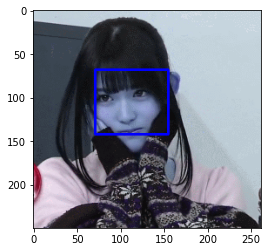

In [64]:
case_1 = video_transformer(video_path = data_path,
                           save_path = os.path.join(path, "data", "frames"),
                           file_name = 'girl.gif',
                           display=True)
case_1.main_transformation("mtcnn", case_1.mean_blur)
case_1.output()

In [15]:


import os

from IPython import display
workers = 0 if os.name == 'nt' else 4

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


In [4]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [6]:
mtcnn = MTCNN(keep_all=True, device=device)

In [17]:
video = mmcv.VideoReader(os.path.join(path, "data", "hamilton_clip.mp4"))
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]

ValueError: To embed videos, you must pass embed=True (this may make your notebook files huge)
Consider passing Video(url='...')